<a href="https://colab.research.google.com/github/viestursjl/LVTagger/blob/master/notebooks/hfst.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Galīgo automātu lietojums morfoloģiskajā apstrādē | Finite state automata for morphology processing

Helsinki Finite State Transdusers (HFST)

Skat. arī.: https://github.com/hfst/compmorph-course/tree/v1.0

In [ ]:
# !pip install hfst

In [ ]:
!pip install hfst_dev

In [ ]:
# import hfst as hfst
import hfst_dev

In [ ]:
help(hfst_dev)

In [ ]:
help(hfst_dev.compile_lexc_file)

In [ ]:
help(hfst_dev.compile_twolc_file)

## Vārdformu ģenerators | Word form synthesis





### LV: Leksikons kodā | EN: Small lexicon in code

In [ ]:
from hfst_dev import compile_lexc_script

In [ ]:
gen = compile_lexc_script(
"""
!Define all symbols consisting of multiple characters
Multichar_Symbols
        +N      ! Noun tag
        +Sg     ! Singular
        +Pl     ! Plural
        +Nom
        +Gen
        +Dat
        +Acc
        +Loc

!Define root lexicon
LEXICON Root
        Nouns ; ! No input, no output


!Define noun lexicon
LEXICON Nouns

rok N4dekl ;

! Define 4th declension paradigm

LEXICON N4dekl
+N+Sg+Nom:^a  # ;
+N+Sg+Gen:^as # ;
+N+Sg+Dat:^ai # ;
+N+Sg+Acc:^u # ;
+N+Sg+Loc:^ā # ;
+N+Pl+Nom:^as  # ;
+N+Pl+Gen:^u  # ;
+N+Pl+Dat:^ām # ;
+N+Pl+Acc:^as # ;
+N+Pl+Loc:^ās # ;


END
""", verbosity=2
)


In [ ]:
print(gen.lookup('rok+N+Sg+Dat'))
## 0 izvadā ir svars

### LV: Leksikons atsevišķā failā | EN: Lexicon in separate file

In [ ]:
!wget https://github.com/LUMII-AILab/NLP_Course/blob/main/notebooks/resources/lvLex.lexc

In [ ]:
#import hfst
generator = hfst_dev.compile_lexc_file('lvLex.lexc')
print(generator.lookup('rok+N+Sg+Gen'))

## Transdjūseri: divu līmeņu morfoloģija | Transducers: two level morphology


### LV: Morfoloģiskā analīze un sintēze | EN: Morphologycal analysis and synthesis


In [ ]:
# Sintēze | Generation
from hfst_dev import HfstTransducer
analyzer = HfstTransducer(generator) # create a copy
print(analyzer.lookup('rok+N+Sg+Nom'))


In [ ]:
# Analīze | Analysis
# We need to invert the transducer to get an analyzer
# After inversion, it is good to minimize the transducer (i.e. reduce it to an equivalent transducer with the smallest number of states).

analyzer.invert()
analyzer.minimize()
print(analyzer.lookup('rok^a'))

In [ ]:
# salīdzināšana | comparison
analyzer.invert()
analyzer.minimize()
print(analyzer.compare(generator))

## FST kaskādēšana | **Cascading**

Pārveidošanas likumi
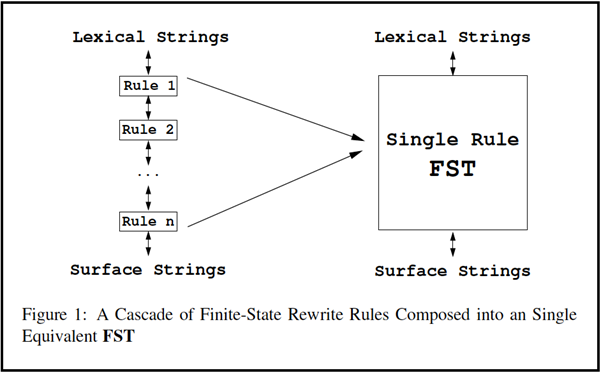

In [ ]:
from hfst_dev import regex, HfstTransducer

Iespraušana

In [ ]:
#Insertion
InsertJ = hfst_dev.regex('[..] -> j || [b | f | m | p | v] _ "^" M')
print(InsertJ.lookup("ķirb^Ma'"))

Aizstāšana

In [ ]:
# Replacement
CReplacement = hfst_dev.regex('c -> č ||  _ "^" M')
print(CReplacement.lookup("lāc^Ma'"))






Izņēmumi

In [ ]:
#Exceptions
Exceptions = hfst_dev.regex('[[{puik} "+N" "+Sg" "+Dat" .x. {puikam}] ]')


Dzēšana

In [ ]:
#Deleting
MCleanup = hfst_dev.regex('M -> 0')
Cleanup = hfst_dev.regex('"^" -> 0')
print(MCleanup.lookup("lāč^Ma'"))

## FST apvienošana | Copmpsition

In [ ]:
# Sintēze | Generation
from hfst_dev import compose
cascade = compose((generator, InsertJ, CReplacement, MCleanup,Cleanup))
print(cascade.lookup("rok+N+Pl+Loc"))


In [ ]:
#if you use hfst library you will need to remove Epsilon symbol also
#cascade.remove_epsilons()
#print(cascade.lookup("rok+N+Pl+Loc")[0][0].replace("@_EPSILON_SYMBOL_@", ""))






In [ ]:
# Analīze | Analysis
inv = hfst_dev.HfstTransducer(cascade)
inv.invert()
inv.convert(hfst_dev.ImplementationType.HFST_OL_TYPE)
print(inv.lookup("ķirbja"))